<a href="https://colab.research.google.com/github/gmxavier/FAT0413150/blob/main/notebooks/05.03-Lunar-Lander-Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
try: 
  import control as ct
except:
  !pip install control
  import control as ct
try:
  from lunar_lander import lunar_engine_output, lunar_control_output, lunar_update, landing_plot
except:
  # To get the file
  from requests import get
  repo_url = 'https://raw.githubusercontent.com/gmxavier/FAT0413150/main/'
  for file in ['lunar_lander.py']:
    url = repo_url+'src/'+file
    with open(file, 'w') as f: 
      f.write(get(url).text)
  # To load it and import the functions
  from lunar_lander import lunar_engine_output, lunar_update, landing_plot

# Lunar lander control

We will use all the codes we've done so far (e.g. models, simulation & plot functions) and everything we need is [here](https://github.com/gmxavier/FAT0413150/blob/main/src/lunar_lander.py) and loaded.

But in order to develop a control loop we will need to create the input/output models for the process (lunar lander dynamics) and the actuator (lunar lander engine).

For the sake of simplicity we assume that the sensor has no dynamics and an unity gain, so we won't create the input/output models for it.



In [ ]:
# To create the input/output model for the actuator
lunar_engine = ct.NonlinearIOSystem(None, 
                                    lunar_engine_output, 
                                    inputs  = ('T_t', 'T_l', 'm_t', 'p_y'), 
                                    outputs = ('F_t', 'F_l'), 
                                    name    = 'lunar_engine')

# To create an input/output model for the process
lunar_dynamics = ct.NonlinearIOSystem(lunar_update, 
                                      None, 
                                      inputs  = ('F_t', 'F_l'), 
                                      outputs = ('p_x', 'v_x', 'p_y', 'v_y', 
                                                 'theta', 'v_theta', 'm_t', 
                                                 'm_f'), 
                                      states  = ('p_x', 'v_x', 'p_y', 'v_y', 
                                                 'theta', 'v_theta', 'm_t', 
                                                 'm_f'), 
                                      name    = 'lunar_dynamics')

## Vertical position control

The goal of the lunar lander vertical position control is to make the controlled variable $p_y$ goes from $160km$ to $0km$. Actually we don't need a controller for this, since the moon's gravity acceleration will do the job for us at no cost! 😀

Unfortunately, if we do anything and let the moon's gravity acceleration do the job, we will end up crashing the lunar lander, no land it! 😞

Definetely we will need a controller in order to make the lunar lander touch down on moon at a safety vertical speed (e.g. $\lt1.0m/s$).

So, let's create the input/output model for the lunar lander vertical position controller.

In [ ]:
# To create the input/output model for the controller
lunar_controller = ct.NonlinearIOSystem(None, 
                                        lunar_control_output, 
                                        inputs  = ('SP', 'PV', 'dPV'), 
                                        outputs = ('CO'), 
                                        name    = 'lunar_controller')

Now let's build the closed loop control system.

In [ ]:
# Closed loop control system
land = ct.InterconnectedSystem(
    # List of subsystems
    (lunar_engine, lunar_dynamics, lunar_controller), name='land',

    # Interconnections between subsystems
    connections=(
        ['lunar_controller.PV',  'lunar_dynamics.p_y'],
        ['lunar_controller.dPV', 'lunar_dynamics.v_y'],
        ['lunar_engine.T_t',     'lunar_controller.CO'],
        ['lunar_engine.m_t',     'lunar_dynamics.m_t'],
        ['lunar_engine.p_y',     'lunar_dynamics.p_y'],
        ['lunar_dynamics.F_t',   'lunar_engine.F_t'],
        ['lunar_dynamics.F_l',   'lunar_engine.F_l']
    ),

    # System inputs
    inplist=['lunar_controller.SP', 'lunar_engine.T_l'],
    inputs=['SP', 'T_l'],

    # System outputs
    outlist=['lunar_engine.T_t', 'lunar_engine.T_l', 'lunar_dynamics.p_x', 
             'lunar_dynamics.v_x', 'lunar_dynamics.p_y', 'lunar_dynamics.v_y', 
             'lunar_dynamics.theta', 'lunar_dynamics.v_theta', 
             'lunar_dynamics.m_t', 'lunar_dynamics.m_f'],
    outputs=['T_t', 'T_l', 'p_x', 'v_x', 'p_y', 'v_y', 
             'theta', 'v_theta', 'm_t', 'm_f'],
    
    # Subsystems parameters
    params={
        # Controller gains
        'K_P' : 0.0e-00, # proportional gain (24504)
        'K_D' : 0.0e-00 # derivative gain (5602)
        # Other parameters ...
            }
)

Finally, let's setup the simulation, run it and see what happens.

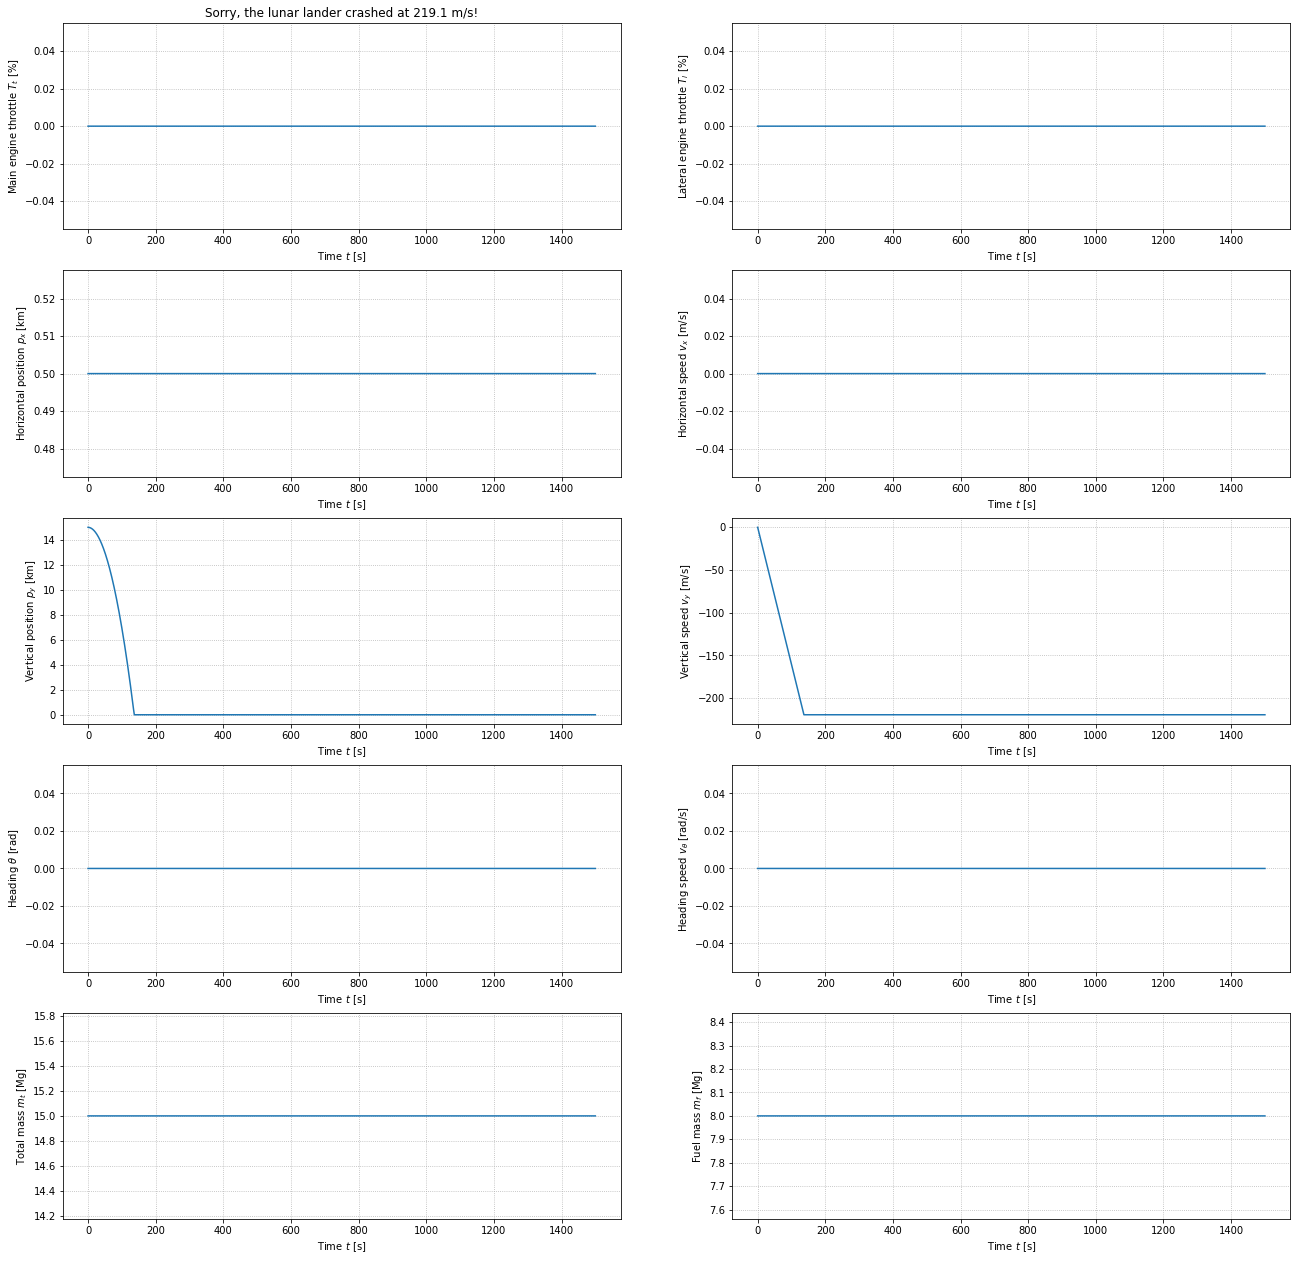

In [ ]:
# Initial conditions
# p_x = 0.5 km, v_x = 0 m/s, p_y = 15.0 km, v_y = -0.75 m/s, theta = 0 rad, v_theta = 0 rad/s, m_t = 15.0 Mg, m_f = 8.0 Mg
x0 = [0.5e+03, 0.0, 15.0e+03, -0.75e+00, 0.0, 0.0, 15.0e+03, 8.0e+03]
# Total simulation time
Tf = 1500
# Simulation time array
T  = np.linspace(0, Tf, 10*Tf+1)
# Inputs
SP   = np.array([0*T]) # the TDP is at the origin
#SP   = np.array([0 if t < 360 else 1.0e+03 if t < 540 else 1.3e+03 for t in T])
T_l  = np.array([0*T]) # no horizontal control
# Simulate and plot
res = landing_plot(land, T, [SP,T_l], x0, params={})

Ooops! 🙀 The lunar lander crashed at $v_y \gt 200 m/s$ on our first trial!

Our first trial looks like this ...

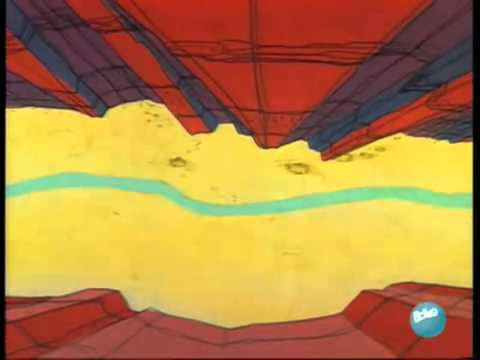

In [ ]:
YouTubeVideo('XCDKJQ3Z8bU')

What went wrong? 🤔

## Horizontal position control

Under construction! 🚧

The goal of the lunar lander horizontal position control is to make the controlled variable $p_x$ goes from $0.5km$ to $0km$.

So, let's play ball!

## Optimal control

Under construction! 🚧

The landing control is nonlinear and it's hard to solve using simple controllers like the PID ones. Let's try to solve the landing control problem using another tool: the optimal control.

In [ ]:
import control.optimal as opt
x0 = [0.5e+03, 0.0, 160.0e+03, -0.7e+03, 0.0, 0.0, 15.0e+03, 8.0e+03]; u0 = [44.0e3, 0.0]
xf = [0.5e+03, 0.0,   0.0e+03,  0.0e+03, 0.0, 0.0,  7.0e+03, 0.0e+03]; uf = [ 0.0e3, 0.0]
Tf = 1000

In [ ]:
# To create an input/output model for the dynamics
def lunar_output(t, x, u, params={}):
  return np.array([x[2], 
                   x[3]])

lunar_dynamics = ct.NonlinearIOSystem(lunar_update, 
                                      lunar_output, 
                                      inputs  = ('F_t', 'F_l'), 
                                      outputs = ('p_y', 'v_y'),
                                      states  = 8,  
                                      name    = 'lunar_dynamics')

In [ ]:
Q = np.diag([0.1, 0.1, 10.0, 10.0, 0.1, 0.1, 10.0, 10.0])    
R = np.eye(2) * 0.1
cost = opt.quadratic_cost(lunar_dynamics, Q, R, x0=xf, u0=uf)

In [ ]:
constraints = [ opt.input_range_constraint(lunar_dynamics, [0.0, 0.0], [44.0e3, 0.0]) ]

In [ ]:
horizon = np.linspace(0, Tf, 100, endpoint=True)
full_throtlle = [20.0e3, 0.0]        # slight left veer

result = opt.solve_ocp(
    lunar_dynamics, horizon, x0, cost, constraints, initial_guess = full_throtlle)    # set step size for gradient calculation

# Extract the results
u = result.inputs
t, y = ct.input_output_response(lunar_dynamics, horizon, u, x0)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_constraints.py:410: OptimizeWarning: Equality and inequality constraints are specified in the same element of the constraint list. For efficient use with this method, equality and inequality constraints should be specified in separate elements of the constraint list. 
  "in separate elements of the constraint list. ", OptimizeWarning)


Summary statistics:
* Cost function calls: 414
* Constraint calls: 1031
* System simulations: 1407
* Final cost: 35223391941025.58


/usr/local/lib/python3.7/dist-packages/control/optimal.py:864: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Inequality constraints incompatible
  "scipy.optimize.minimize returned " + res.message, UserWarning)
